# CAICT 風機結冰預測 - Deep Learning

2017/07/12  
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

# **1. Load Data and Modules**

**Load Python modules:**

In [87]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import pandas as pd
import os
import sys
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import shutil
import csv
import sklearn as sk
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from IPython.core.interactiveshell import InteractiveShell
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential

from sklearn import preprocessing

import keras.backend as K
import numpy as np
import random
import sys
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"

In [88]:
def updateProgress(msg):
    sys.stdout.write('\r')
    sys.stdout.write(msg)
    sys.stdout.flush()
    
def myscore(true_y, pred_y):
    n,p =sk.metrics.confusion_matrix(true_y, pred_y)
    tn = n[0]
    fp = n[1]
    fn = p[0]
    tp = p[1]
    #print('tn:',tn,'fp:',fp,'fn:',fn,'fp:',fp)
    score = 1- 0.5*(fp/(tn+fp))- 0.5*(fn/(fn+tp)) 
    #print('score',score)
    return score, {'tn':tn,'fp':fp,'fn':fn,'tp':tp}


In [154]:
def StandardScaler(data):
    standard_scaler = preprocessing.StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled

def MinMaxScaler(data):
    standard_scaler = preprocessing.MinMaxScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled



##------------------------

def load_resample_data(mid, policy=1,  ycol='power', fillna=0):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    print('load file:',filename)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(fillna)
    data_resample[data_resample['label']==2]=0
    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    #data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    non_data_cols = ['label','time','group','timestamp','event']
    data_scaled = MinMaxScaler(data_X)
    for col in non_data_cols:
        data_scaled[col] = data_resample[col]
    return data_resample,data_scaled

##------------------------

def load_test2_data():
    test_data = pd.read_csv('data/ice1/test/08/08_data.csv')
    test_timeidx = test_data['time']
    tmp = test_data.drop(['time','group','generator_speed'], axis=1)
    test_X = tmp.values
    return test_X, test_timeidx

    

In [90]:
def rnn_dataset(data, n_steps):
    dataset_new = []
    for idx, _ in enumerate(data):
        start_idx = idx-n_steps
        end_idx = idx+1
        if start_idx<0:
            continue
        n=np.concatenate(data[start_idx:end_idx], axis=0)
        dataset_new.append(n)
    dataset_new = np.asarray(dataset_new)
    return dataset_new
    

**Load input data.** 

In [86]:
xcols=['wind_speed', 'wind_direction',
       'wind_direction_mean', 'yaw_position', 'yaw_speed', 'pitch1_angle',
       'pitch2_angle', 'pitch3_angle', 'pitch1_speed', 'pitch2_speed',
       'pitch3_speed', 'pitch1_moto_tmp', 'pitch2_moto_tmp', 'pitch3_moto_tmp',
       'acc_x', 'acc_y', 'environment_tmp', 'int_tmp', 'pitch1_ng5_tmp',
       'pitch2_ng5_tmp', 'pitch3_ng5_tmp', 'pitch1_ng5_DC', 'pitch2_ng5_DC',
       'pitch3_ng5_DC']


In [115]:
_, data_scaled_M15 = load_resample_data(mid=15,policy=4)

data_M15_train = data_scaled_M15[data_scaled_M15['event']<20]
data_M15_valid = data_scaled_M15[data_scaled_M15['event']>=20]

ycol='label'
data_M15_train_X = data_M15_train[xcols]
data_M15_train_y = data_M15_train[ycol]
data_M15_train_Y = np.eye(data_M15_train_y.unique().size)[data_M15_train_y.values.astype(int)]

data_M15_valid_X = data_M15_valid[xcols]
data_M15_valid_y = data_M15_valid[ycol]
data_M15_valid_Y = np.eye(data_M15_valid_y.unique().size)[data_M15_valid_y.values.astype(int)]


_, data_scaled_M21 = load_resample_data(mid=21,policy=0)
data_M21_test_X = data_scaled_M21[xcols]
data_M21_test_y = data_scaled_M21[ycol]
data_M21_test_Y = np.eye(data_M21_test_y.unique().size)[data_M21_test_y.values.astype(int)]


#_, data_X_M21, data_Y_M21, data_y_M21  = load_training_data(mid=21,policy=0)

#_, data_X_M21, data_Y_M21, data_y_M21  = load_training_data(mid=21,policy=0)
#test_X,test_timeidx = load_test2_data()

load file: data/resample_data_p4_15.csv
load file: data/resample_data_p0_21.csv


** 為了RNN需求, 更改X format **

In [133]:
n_steps = 50
n_steps_=n_steps-1
data_M15_train_X_new = rnn_dataset(data_M15_train_X.values,n_steps_)
data_M15_valid_X_new = rnn_dataset(data_M15_valid_X.values,n_steps_)
data_M21_test_X_new = rnn_dataset(data_M21_test_X.values,n_steps_)
#test_X = rnn_dataset(test_X,n_steps_)

data_M15_train_X_new = data_M15_train_X_new.reshape([-1, 50, len(xcols)])
data_M15_valid_X_new = data_M15_valid_X_new.reshape([-1, 50, len(xcols)])
data_M21_test_X_new = data_M21_test_X_new.reshape([-1, 50, len(xcols)])
#test_X = test_X.reshape([-1, 50, len(xcols)])

In [150]:
data_M15_train_Y_new=data_M15_train_Y[n_steps_:]
data_M15_train_y_new=data_M15_train_y[n_steps_:]
data_M15_valid_Y_new=data_M15_valid_Y[n_steps_:]
data_M15_valid_y_new=data_M15_valid_y[n_steps_:]
data_M21_test_Y_new=data_M21_test_Y[n_steps_:]
data_M21_test_y_new=data_M21_test_y[n_steps_:]
#test_timeidx_new=test_timeidx[n_steps_:]

## 3. Deep Learning

In [138]:
#model1 = Sequential()
#model1.add(LSTM(512, input_shape=(50, 25),dropout=0.2, recurrent_dropout=0.2))
#model1.add(Dense(2))
#model1.add(Activation('softmax'))
#optimizer = Adam(lr=0.001)
#model1.compile(loss='categorical_crossentropy', optimizer=optimizer)

model1 = Sequential()
model1.add(LSTM(50, input_shape=(50, len(xcols)), return_sequences=True))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(LSTM(100,return_sequences=False))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(2))
model1.add(Activation('softmax'))
optimizer = Adam(lr=0.001)
model1.compile(loss="binary_crossentropy", optimizer=optimizer)



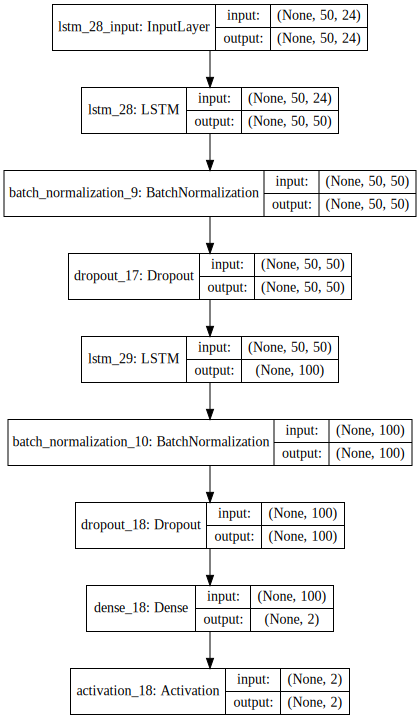

In [157]:
SVG(model_to_dot(model1, show_shapes=True).create(prog='dot', format='svg'))

In [158]:
model1.fit(data_M15_train_X_new, data_M15_train_Y_new, batch_size=500, epochs=20)


Epoch 1/20
30000/78307 [==========>...................] - ETA: 8s - loss: 0.0128

KeyboardInterrupt: 

** 4. 預測與準確率評估  Evaluation **

In [149]:
data_M15_train_y.shape

(78356,)

In [151]:
ret = model1.predict(data_M15_train_X_new)
pred_t = pd.DataFrame(ret)
pred_t = pred_t.apply(np.argmax,axis=1)
pd.Series(data_M15_train_y_new).value_counts()
pred_t.value_counts()
print("Precision", precision_score(data_M15_train_y_new, pred_t))
print("Recall", sk.metrics.recall_score(data_M15_train_y_new, pred_t))

s,_=myscore(data_M15_train_y_new, pred_t)
print('score',s,_)

0    32518
1    23671
dtype: int64

0    54502
1    23805
dtype: int64

Precision 0.980592312539
Recall 0.986143382198
score 0.988843709548 {'tn': 54174, 'fp': 462, 'fn': 328, 'tp': 23343}


In [152]:
ret = model1.predict(data_M15_valid_X_new)
pred_t = pd.DataFrame(ret)
pred_t = pred_t.apply(np.argmax,axis=1)
pd.Series(data_M15_valid_y_new).value_counts()
pred_t.value_counts()
print("Precision", precision_score(data_M15_valid_y_new, pred_t))
print("Recall", sk.metrics.recall_score(data_M15_valid_y_new, pred_t))

s,_=myscore(data_M15_valid_y_new, pred_t)
print('score',s,_)

0    8586
1    4310
dtype: int64

1    8599
0    4297
dtype: int64

Precision 0.390394231887
Recall 0.778886310905
score 0.584178771572 {'tn': 3344, 'fp': 5242, 'fn': 953, 'tp': 3357}


In [153]:
ret = model1.predict(data_M21_test_X_new)
pred_t = pd.DataFrame(ret)
pred_t = pred_t.apply(np.argmax,axis=1)
pd.Series(data_M21_test_y_new).value_counts()
pred_t.value_counts()
print("Precision", precision_score(data_M21_test_y_new, pred_t))
print("Recall", sk.metrics.recall_score(data_M21_test_y_new, pred_t))

s,_=myscore(data_M21_test_y_new, pred_t)
print('score',s,_)

0    8586
1    4310
dtype: int64

1    99899
0    90546
dtype: int64

Precision 0.0877185957817
Recall 0.823745064862
score 0.658445246508 {'tn': 88671, 'fp': 91136, 'fn': 1875, 'tp': 8763}


***
#### Predict Test Data

In [ ]:
test_X_rs = test_X.reshape([-1, n_steps, n_inputs])
test_X_rs__1 = test_X_rs[:100000]
pred_T1 = pd.DataFrame(pred.eval({X: test_X_rs__1}))
pred_T1 = pred_T1.apply(np.argmax,axis=1)
pred_T1.value_counts()

test_X_rs__2 = test_X_rs[100000:]
pred_T2 = pd.DataFrame(pred.eval({X: test_X_rs__2}))
pred_T2 = pred_T2.apply(np.argmax,axis=1)
pred_T2.value_counts()



In [ ]:
pred_T = pred_T1.append(pred_T2)
pred_T.shape
pred_T.value_counts()

## 5. 整理預測結果, 正確上傳格式

In [ ]:
pred_T.shape

In [ ]:
startTime=0
endTIme=0
search_start=True
search_end=False
abnormal_list=[]
shift = test_timeidx_new.index[0]
for i,v in enumerate(pred_T):
    i=i+shift
    if (v==1) & (search_start):
        startTime = test_timeidx_new[i]
        search_end=True
        search_start=False
    if (v==0) & (search_end):
        endTIme=test_timeidx_new[i]
        search_start=True
        search_end=False
        abnormal_list.append((startTime,test_timeidx_new[i-1]))
len(abnormal_list)

In [ ]:
output_ans=True
if(output_ans):
    with open('test1_08_results.csv','w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['startTime','endTime'])
        for row in abnormal_list:
            dummy = csv_out.writerow(row)

print('done')


In [ ]:
abnormal_list[:4]

## 6. Issue
1. Data Imbalance
 - training batch sample 一半normal一半abnormal的data
 - 用兩台風機訓練兩個model, 取故障預測的聯集 

2. 用Precision & Recall評估好壞, 算出Score


other:
- using weighted examples. Just amplify the per-instance loss by a larger weight when seeing positive examples. If you use online gradient descent, it can be as simple as using a larger learning rate when seeing positive examples.
- A similar and slightly better approach (only if you use stochastic gradient descent) is randomly picking an example in each iteration, where the positive examples have higher probability of being picked.

提交结果历史记录  
参赛队伍:　556 / 参赛人数:　858  
 
|竞赛阶段	 |上传者	 |分数	 |提交日期	 |排名	 |下载|
| ---------| -------- | ------ | ------ | ------ | ------ |
|初赛test1阶段|	孔祥千	|55.28684214|	2017/7/12|	50	|下载|

Note: 7/13
1. cross correlation
2. auto correlation
3. common filter
4. de-train 